# Toy Project Analyzing my Spotify Playlist
Data crawled with https://dev.peterfiorella.com/spotifyexport/public/#

In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

In [2]:
# Read the JSON file
with open('spotify-playlists-2023-07-18.json') as f:
    data = json.load(f)

# Extract the "tracks" field from the first object in the array
tracks = data[0]['tracks']

# Normalize the "tracks" field into a DataFrame
df = pd.json_normalize(tracks)

print(df.head())

                                 name                    artist  \
0  Shine - Gabriel Drew & Bloom Remix                  Spektrem   
1                         Why We Lose  [Cartoon, Coleman Trapp]   
2                               Alone              Main Reaktor   
3                        Collins Ave.                    Umpire   
4                             Cloud 9              [Tobu, Itro]   

                                album                                   uri  
0  Shine (Gabriel Drew & Bloom Remix)  spotify:track:157s6uDH7vmaomqnGd2uab  
1                         Why We Lose  spotify:track:5NmENli4oodYuWrI0vSGK4  
2                               Alone  spotify:track:7kDwexX6zo1rA5ekQcIhG0  
3                        Collins Ave.  spotify:track:0pNo7OBAmqnSUL18dYAAPx  
4                             Cloud 9  spotify:track:7pPoBydlANHqWDYgm2DkSK  


In [3]:
# Helper functions

def getCountsFromDict(df, key):
  ret = {}

  for i in df[key]:
    if type(i) == list:
      for j in i:
        if j in ret:
          ret[j] += 1
        else:
          ret[j] = 1
    else:
      if i in ret:
        ret[i] += 1
      else:
        ret[i] = 1

  # Sort the dictionary by value
  ret = dict(sorted(ret.items(), key=lambda item: item[1], reverse=True))
  return ret

def getAlbumCountsFromDict(df):
  ret = {}
  key = 'album'

  for i in df[key]:
    # Get the artist name from original df
    artist = df[df[key] == i]['artist']

    artist = artist.iloc[0]
    if type(artist) == list:
      artist = artist[0]

    if i + " #-# " +  artist in ret:
      ret[i + " #-# " + artist] += 1
    else:
      ret[i + " #-# " + artist] = 1

  # Sort the dictionary by value
  ret = dict(sorted(ret.items(), key=lambda item: item[1], reverse=True))
  return ret

## Album statistics

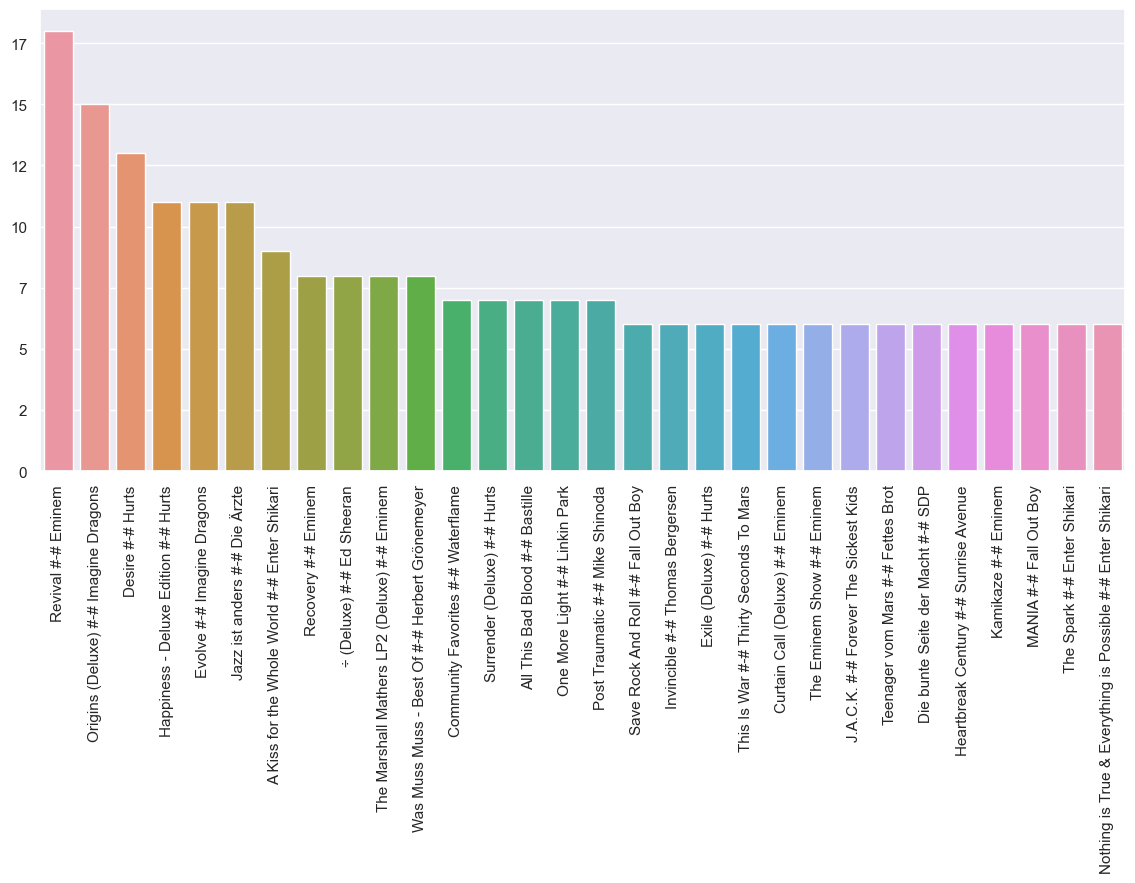

In [7]:
album = getAlbumCountsFromDict(df)

# Print the top 30 albums in a bar chart with seaborn

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})
plot = sns.barplot(x=list(album.keys())[:30], y=list(album.values())[:30])
plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(rotation=90)
plt.show()

## Artist statistics

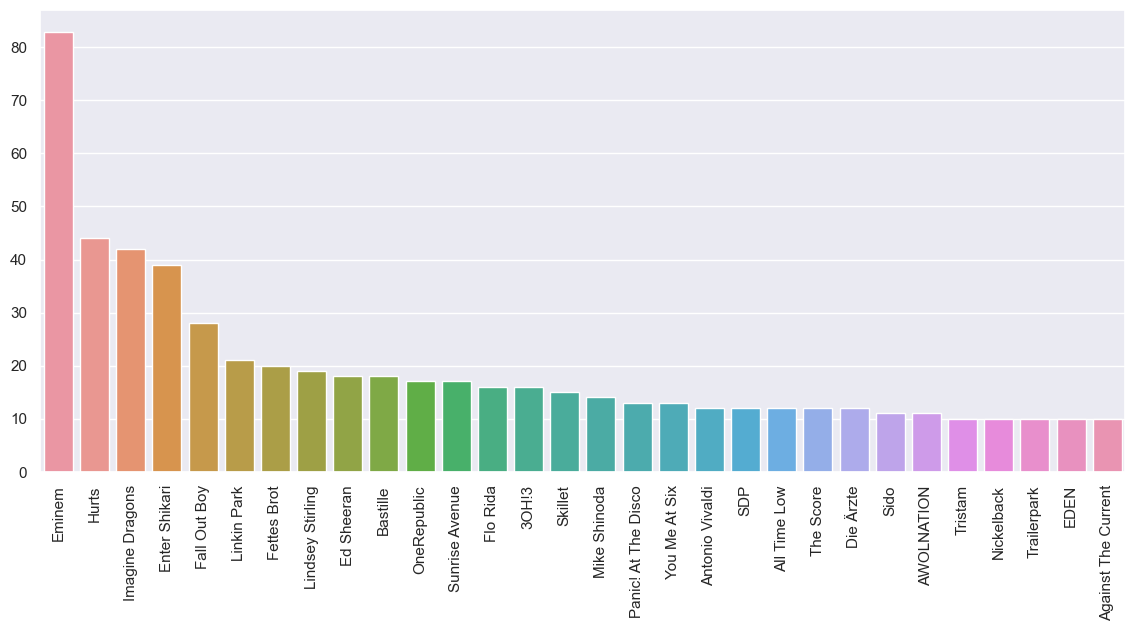

In [133]:
artist = getCountsFromDict(df, 'artist')

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(14,6)})
plot = sns.barplot(x=list(artist.keys())[:30], y=list(artist.values())[:30])
plot.yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.xticks(rotation=90)
plt.show()

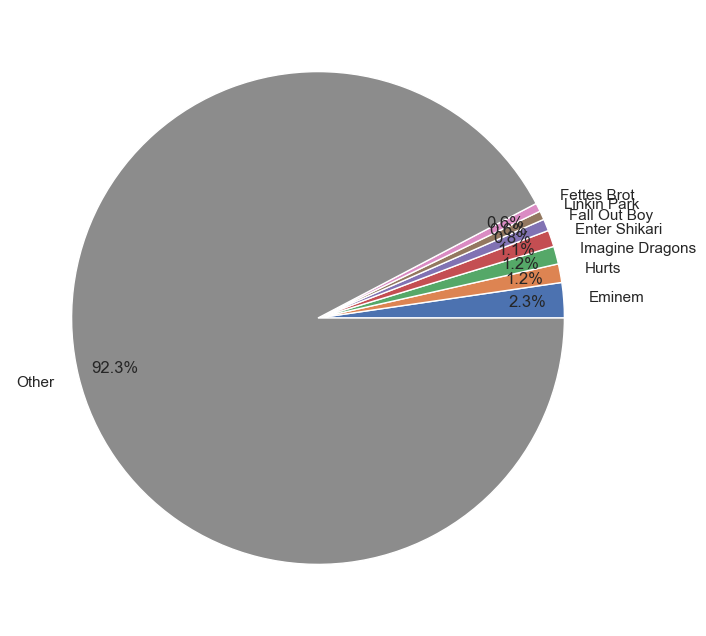

In [5]:
# Create Pie Chart of all artists binning all artists with less than gamma % of total songs into "Other"
artist = getCountsFromDict(df, 'artist')

# Get the total number of songs
total = df.shape[0]
gamma = 0.7

# Get the total number of songs by artists with more than gamma % of total songs
totalTop = 0
for i in artist:
  if artist[i]/total > gamma / 100:
    totalTop += artist[i]

# Create a new dictionary with all artists with less than gamma % of total songs binned into "Other"
artistPie = {}
for i in artist:
  if artist[i]/total > gamma / 100:
    artistPie[i] = artist[i]
  else:
    if "Other" in artistPie:
      artistPie["Other"] += artist[i]
    else:
      artistPie["Other"] = artist[i]

# Create the pie chart
plt.pie(artistPie.values(), labels=artistPie.keys(), autopct='%1.1f%%', pctdistance=0.85, labeldistance=1.1)
plt.show()

In [6]:
# Filtering Tracks with Multiple Artists
filtered_df = df[df['artist'].apply(lambda x: isinstance(x, list))]
print(filtered_df.shape[0])

# Building FP-Growth Tree
te = TransactionEncoder()
te_ary = te.fit(filtered_df['artist']).transform(filtered_df['artist'])
fp_df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = fpgrowth(fp_df, min_support=0.001, use_colnames=True)

# Generating Association Rules with Confidence
association_results = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sorting and Printing Frequent Itemsets with Confidence
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
print(frequent_itemsets.head(10))

# Sorting and Printing Association Rules with Confidence
association_results = association_results.sort_values(by='confidence', ascending=False)
print(association_results.head(10))

659
       support                                 itemsets
187   0.048558                                 (Eminem)
58    0.018209                        (Antonio Vivaldi)
63    0.015175                               (Flo Rida)
71    0.013657                       (Lindsey Stirling)
67    0.012140                       (Thomas Bergersen)
41    0.012140                           (Robin Schulz)
66    0.012140                    (Two Steps from Hell)
1217  0.012140  (Thomas Bergersen, Two Steps from Hell)
100   0.010622                           (Fall Out Boy)
94    0.010622                                   (Sido)
                                             antecedents  \
10232                                       (Supermario)   
13555  (Cram, Der Tobi & Das Bo, Supermario, Eißfeldt...   
13562  (Cram, Supermario, Tabularasa, Eißfeldt, Fette...   
13561  (Cram, Supermario, Tabularasa, Eißfeldt, Fisch...   
13560  (Cram, Der Tobi & Das Bo, Eißfeldt, Fischmob, ...   
13559  (Der Tobi & D